# UNet2D-tiff

In [1]:
import logging
import sys
import os.path
from collections import namedtuple
from itertools import chain

import emsa

import numpy as np
import pandas as pd
import scipy
from scipy import ndimage
from scipy import ndimage as ndi
from scipy.misc import imsave
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

import unet
from unet.utils import BinCounter

%pylab inline
plt.rcParams["figure.figsize"] = (12, 8)

Dataset = namedtuple('Dataset', ['image', 'mask', 'coords', 'radius'])

logger = logging.getLogger(__name__)

# Tool to debug the code in python
# import IPython
# IPython.embed()

Populating the interactive namespace from numpy and matplotlib


/home/mas/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
unet.config_logger("/dev/null")

In [3]:
# Function that permit us to detect/work with the centers and no with the projections of the dilation
def nonmaxima_suppression(img, return_mask=True):
    # smooth_img = img # ndi.gaussian_filter(img, 1)
    dilated = ndi.grey_dilation(img, (5,) * img.ndim)
    argmaxima = np.logical_and(img == dilated, img > 0.5)

    argwhere = np.argwhere(argmaxima)

    if not return_mask:
        return argwhere

    return argwhere, argmaxima

In [4]:
def inverse_argwhere(coords, shape, dtype):
    
    res = np.zeros(shape, dtype=dtype)
    intcoords = np.int_(np.round(coords))
    res[intcoords[:, 0], intcoords[:, 1], intcoords[:, 2]] = 1
    return res

In [5]:
def precision_and_recall(testing_coords, pred_coords, match_distance):
    w = scipy.spatial.distance_matrix(testing_coords, pred_coords)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(w)

    res = []
    for i in range(row_ind.shape[0]):
        if w[row_ind[i], col_ind[i]] <= match_distance:
            res.append(w[row_ind[i], col_ind[i]])

    precision = len(res) / len(pred_coords)
    recall = len(res) / len(testing_coords) 
    
    return precision, recall, len(res), len(pred_coords), len(testing_coords)

In [6]:
def reduce_metrics(results):
    
    tp = sum(i.tp for i in results)
    tp_fp = sum(i.tp_fp for i in results)
    tp_fn = sum(i.tp_fn for i in results)
    true_sums = np.array([i.true_sums for i in results])
    pred_sums = np.array([i.pred_sums for i in results])
    volumes = np.array([i.volumes for i in results])
    
    precision = tp / tp_fp
    recall = tp / tp_fn
    
    error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)
    
    return Metrics(precision, recall, tp, tp_fp, tp_fn,
                   error, true_sums, pred_sums, volumes)

In [7]:
def Dilation(labels):
#     # 3D dilation using euclidean distances.
#     distance = ndimage.distance_transform_edt(1 - labels) # Distance to the nearest black point. We need the distance to the white.
#     labels2 = np.int16(distance < 2.4) # The threshold by the centers of the vesicles.
#     labels = np.int16(distance < 2.4) # Threshold by the area of uncertainty.

#     # '1' is the center and '2' the area of uncertainty
#     labels[labels == 1] = 2 
#     labels[labels2 == 1] = 1 

#     # #Area of uncertainty in the initial mask of the vesicle.
#     # labels[mask == 0] = 2
#     return labels

    gauss = ndi.gaussian_filter(np.float32(labels), 3)
    soft_img =  np.uint8(gauss / np.max(gauss) *255)
    return soft_img


#     s = ndimage.generate_binary_structure(2,1)
# #     dilation = np.int16(ndimage.grey_dilation(labels, footprint=s))
#     dilation = ndi.grey_dilation(labels, (5,) * labels.ndim)
#     return dilation
    

In [8]:
logger.info("Creating the Network...")
num_classes = 2
unet_config = unet.UNetConfig(steps=2,
                              ndims=2,
                              num_classes=num_classes,
                              first_layer_channels=64,
                              num_input_channels=1,
                              two_sublayers=True)

unet_clsf = unet.UNetClassifier(unet_config).cuda() # .cuda() moves the network to GPU

2018-02-05 16:09:25,862 [__main__] Creating the Network...


In [9]:
unet_clsf.load_state_dict(torch.load('cvlabdata1/home/mas/UNet-2D-Task12-FinalResult/network_310000.pth'))

In [10]:
# Cargamos el stack sobre el cual queremos obtener la representación. 

base_path = "/cvlabdata1/home/marquez/vesicles/"
# file = "striatum_testing/Bouton 3"
# file = "hipp_testing/Bouton 1"
file = "glutamate/Bouton 3"

testing_x = np.float32(unet.load_volume(os.path.join(base_path, file, "img.tif")) / 255.0)
testing_coords, radius = np.load(os.path.join(base_path, file, "vesicles.npy"), encoding = 'bytes')
testing_coords = np.vstack(testing_coords)
radius = np.float_(radius)
mask = np.float32(unet.load_volume(os.path.join(base_path, file, "mask.tif"))) 
density = np.float32(unet.load_volume(os.path.join(base_path, file, "density.tif")))

In [11]:
pred_stack = np.array([unet.predict_in_blocks(unet_clsf, i, (100, 100), verbose=False)[1] for i in testing_x])

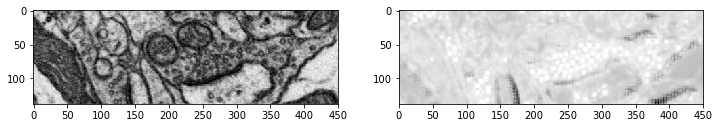

In [12]:
i = 65
plt.subplot(1, 2, 1)
plt.imshow(testing_x[i])
plt.subplot(1, 2, 2)
plt.imshow(pred_stack[i]+testing_x[i])
# plt.imshow((pred_stack[i]) + testing_x[i])

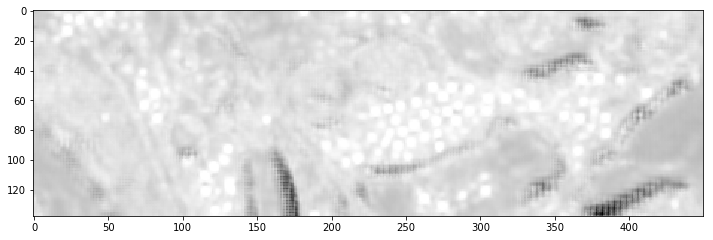

In [13]:
plt.imshow(pred_stack[i])

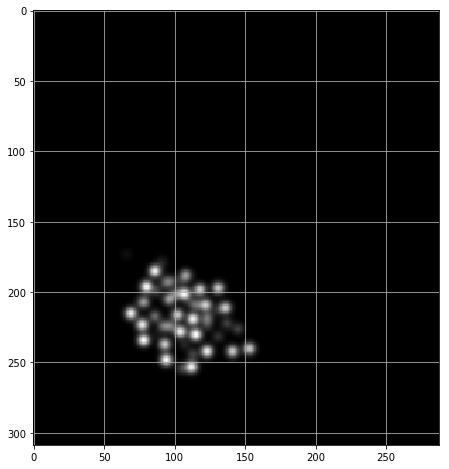

In [63]:
# Obtenemos los centros reales (originales) de las vesículas. (Los originales)

# Load of the centers
ones = np.int64(np.round(testing_coords)) 

# Centers activation with Advanced Indexing
labels = np.zeros(mask.shape, dtype=np.int64)
labels[ones[:, 0], ones[:, 1], ones[:, 2]] = 1
labels = Dilation(labels)
plt.imshow(labels[i])
plt.grid()

In [64]:
# Buscamos la parejas coincidentes entre la predicción y la imagen original. (Trabajamos con los centros)
pred_coords, pred_y = nonmaxima_suppression(pred_stack*mask, True) 
w = scipy.spatial.distance_matrix(testing_coords, pred_coords)
row_ind, col_ind = scipy.optimize.linear_sum_assignment(w)

In [65]:
w.shape

(196, 0)

In [66]:
# Eliminamos aquellas parejas que están a un distacia superior a 4.
match_distance = 4
index_pred = []
index_testing = []
for i in range(row_ind.shape[0]):
    if w[row_ind[i], col_ind[i]] <= match_distance:
        index_pred.append(col_ind[i])
        index_testing.append(row_ind[i])
index_pred = np.hstack(index_pred)
index_testing = np.hstack(index_testing)
# index

IndexError: list index out of range

In [ ]:
# Green = True Positve
green_testing = np.zeros(mask.shape, dtype=np.int16)
ones_green_testing = np.int16(testing_coords[index_testing])
green_testing[ones_green_testing[:, 0], ones_green_testing[:, 1], ones_green_testing[:, 2]] = 1
green_testing = Dilation(green_testing)

In [ ]:
i = 65
plt.subplot(1, 2, 1)
plt.imshow(labels[i])
plt.xlabel("Original Centers", fontsize=18)
plt.grid()
plt.subplot(1, 2, 2)
plt.imshow(green_testing[i])
plt.xlabel("Green_testing Centers", fontsize=18)
plt.grid()
# plt.subplot(1, 2, 2)
# plt.imshow(green_pred[i])
# plt.xlabel("Green_pred Centers", fontsize=18)
# plt.grid()

In [ ]:
# Blue = false positive (Vesículas predichas de más)
# Creamos un conjunto con todos los elementos y eleminamos los de no interés.
index_blue = np.array(list(set(range(w.shape[1])) - set(index_pred))) # index of false positive
blue = np.zeros(mask.shape, dtype=np.int16)
ones_blue = np.int16(pred_coords[index_blue])
blue[ones_blue[:, 0], ones_blue[:, 1], ones_blue[:, 2]] = 1
blue = Dilation(blue)

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(labels[i])
plt.xlabel("Original Centers", fontsize=18)
plt.grid()
plt.subplot(1, 2, 2)
plt.imshow(blue[i])
plt.xlabel("Blue Centers", fontsize=18)
plt.grid()

In [ ]:
# Red = false negative (Vesículas que no hemos sido capaces de predecir)
index_red = np.array(list(set(range(w.shape[0])) - set(index_testing))) # index of false negative
red = np.zeros(mask.shape, dtype=np.int16)
ones_red = np.int16(testing_coords[index_red])
red[ones_red[:, 0], ones_red[:, 1], ones_red[:, 2]] = 1
red = Dilation(red)

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(labels[i])
plt.xlabel("Original Centers", fontsize=18)
plt.grid()
plt.subplot(1, 2, 2)
plt.imshow(red[i])
plt.xlabel("Red Centers", fontsize=18)
plt.grid()

In [ ]:
red.dtype, blue.dtype, green_testing.dtype

In [ ]:
# Creamos el stack final. Y en cada componente RGB guardamos uno de los resultados obtenido.

img = np.zeros(mask.shape + (3,), dtype=np.uint8)
# img = np.zeros(mask.shape + (3,))
img[..., 0] = red
img[..., 1] = green_testing
img[..., 2] = blue
# img[..., 1] = labels

plt.imshow(img[i])
plt.grid()

In [ ]:
# Save like a 'tiff' and use it with FIJI.

import tifffile
# tifffile.imsave("/cvlabdata1/home/mas/Visualization_RGB/pred-worst-final.tif", img)
